# RNN Model

Loading in the word2vec modela and the processed data 

In [1]:
from gensim.models import Word2Vec
import os
import pandas as pd

df = pd.read_csv('Datasets\\processedAnimeReviews.csv')
w2v_model = Word2Vec.load('Models\\w2vmodel.bin')

In [2]:
print(len(w2v_model.wv.vocab))
print(w2v_model.vector_size)

170072
100


Getting a count of all teh words

In [3]:
from collections import Counter
from nltk.tokenize import word_tokenize

vocab = Counter()

def count_words(text: str):
    tokens = word_tokenize(text)
    for token in tokens:
        vocab[token] += 1

df['review'].apply(lambda x: count_words(x))
for value, count in vocab.most_common(20):
    print(value, count)

character 363540
anime 342406
story 224260
show 213578
like 207145
one 194067
really 159586
episode 146563
series 143603
good 131607
time 125444
well 115288
first 109700
get 107283
much 102853
make 101059
even 100143
would 93321
also 90920
thing 87132


Prepping the training and test data

In [4]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences

word_vectors = w2v_model.wv # retrieve word vectors

# enumerating through the dict, and giving each word a specific index to be used for encoding
# The dict will effectively look something like this
# {
#     'character': 1,
#     'anime': 2,
#     ...
# }
# when it comes time for the reviews to get encoded, they will read off this dict and covert their string to an int value
word_index = {t[0]: i+1 for i,t in enumerate(vocab.most_common(len(word_vectors.vocab)))} 

MAX_NB_WORDS = len(word_vectors.vocab)
MAX_SEQ_LEN = 300

# taking review and sentiment from dataframe
reviews = list(df['review'].values)
sentiment = list(df['sentiment'].values)

X_train, X_test, y_train, y_test = train_test_split(reviews,sentiment,test_size=.1, random_state=42) # train test splits

# encoding each word in the reviews with integer in word_index
X_train = [[word_index.get(word, 0) for word in review] for review in X_train] 
X_test = [[word_index.get(word, 0) for word in review] for review in X_test]

# padding/truncating the traind and test review sequences, since RNN prefers to have all its sequences of equal length
X_train = pad_sequences(X_train, maxlen=MAX_SEQ_LEN, padding="post", truncating="post")
X_test = pad_sequences(X_test, maxlen=MAX_SEQ_LEN, padding="post", truncating="post")

print(X_train.shape)
print(X_test.shape)

(121662, 300)
(13519, 300)


Building out the embedding matrix for the embedding layer of model, out of the word vectors

In [5]:
import numpy as np

wv_dim = 100
number_words = len(word_vectors.vocab)
word_vector_matrix = (np.random.rand(number_words, wv_dim) - .5) / 5.0
for word, i in word_index.items():
    if i >= MAX_NB_WORDS:
        continue
    try:
        embedding_vector = word_vectors[word]
        # words not found in embedding index will be all-zeros.
        word_vector_matrix[i] = embedding_vector
    except:
        pass 

In [6]:
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout,SpatialDropout1D, Bidirectional, BatchNormalization, Lambda
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

Building the RNN model sequentially


In [7]:
model = Sequential()
model.add(Input(shape=(MAX_SEQ_LEN,), dtype='int32'))
model.add(Embedding(number_words, wv_dim, mask_zero=False, weights=[word_vector_matrix], input_length=MAX_SEQ_LEN, trainable=False))
model.add(SpatialDropout1D(0.2))
model.add(Bidirectional(LSTM(64, return_sequences=False)))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer=Adam(),
              metrics=['acc'])

Model Training

In [8]:
nd_y_train = np.asarray(y_train)
print(X_train.shape)
print(nd_y_train.shape) 
hist = model.fit(X_train, nd_y_train, validation_split=0.1, epochs=5, batch_size=256, shuffle=True)

(121662, 300)
(121662,)
Train on 109495 samples, validate on 12167 samples
Epoch 1/5
109495/109495 [==============================] - 4364s 40ms/sample - loss: 0.7178 - acc: 0.5391 - val_loss: 0.6802 - val_acc: 0.5648
Epoch 2/5
109495/109495 [==============================] - 4392s 40ms/sample - loss: 0.6816 - acc: 0.5670 - val_loss: 0.6946 - val_acc: 0.5083
Epoch 3/5
109495/109495 [==============================] - 4415s 40ms/sample - loss: 0.6724 - acc: 0.5801 - val_loss: 0.6575 - val_acc: 0.6024
Epoch 4/5
109495/109495 [==============================] - 4406s 40ms/sample - loss: 0.6555 - acc: 0.6015 - val_loss: 0.6431 - val_acc: 0.6223
Epoch 5/5
109495/109495 [==============================] - 4447s 41ms/sample - loss: 0.6401 - acc: 0.6226 - val_loss: 0.6360 - val_acc: 0.6221


In [9]:
model.summary()
model.save(os.path.join(os.getcwd(), 'Models\\rnn.pkl'))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 100)          17007200  
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 300, 100)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               84480     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 17,092,321
Trainable params: 84,865
Non-trainable params: 17,007,456
________________________________________________

Getting evaluation metrics by predicting the test set

In [12]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_auc_score
	
# predict crisp classes for test set
y_classes = model.predict_classes(X_test, verbose=0)


# reduce to 1d array
y_classes = y_classes[:, 0]
	
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_classes)
print(f'Accuracy: {accuracy}')
# precision tp / (tp + fp)
precision = precision_score(y_test, y_classes)
print(f'Precision: {precision}')
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_classes)
print(f'Recall: {recall}')
# f1_score: 2 * (prec * recall) / (prec + recall)
f1_s = f1_score(y_test, y_classes)
print(f'F1 Score: {f1_s}')
# roc_auc
roc_auc = roc_auc_score(y_test, y_classes)
print(f'Roc_Auc score: {roc_auc}')

Accuracy: 0.6225312523115615
Precision: 0.7250299811547027
Recall: 0.547477360931436
F1 Score: 0.6238667354610452
Roc_Auc score: 0.6351137020583937


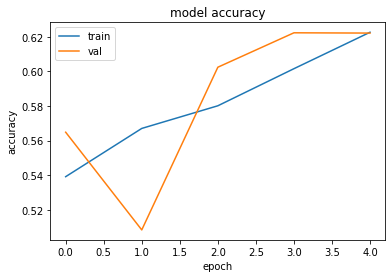

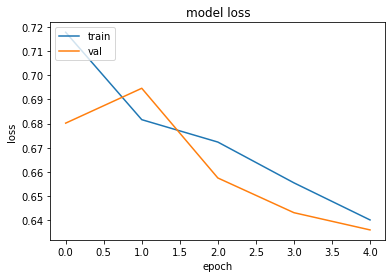

In [15]:
import matplotlib.pyplot as matplt 

# Show the history for accuracy
matplt.plot(hist.history['acc'])
matplt.plot(hist.history['val_acc'])
matplt.title('model accuracy')
matplt.ylabel('accuracy')
matplt.xlabel('epoch')
matplt.legend(['train', 'val'], loc='upper left')
matplt.show()
# Show the history for loss
matplt.plot(hist.history['loss'])
matplt.plot(hist.history['val_loss'])
matplt.title('model loss')
matplt.ylabel('loss')
matplt.xlabel('epoch')
matplt.legend(['train', 'val'], loc='upper left')
matplt.show()